# Exploring spatio-temporal events using public soccer-logs

The data used in the notebook can be found in: 

- Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000.v5

A detailed description of the data can be found in the following paper (please cite it if you use the data or the following code):


- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

## Outline of the notebook

1. [Import libraries](#import_libraries)
2. [Load public datasets](#load_public_dataset)
3. [How are the data collected?](#data_collection)
4. [Structure of data](#structure_of_data)
    1. [Players](#players)
    2. [Competitions](#competitions)
    3. [Matches](#matches)
    4. [Events](#events) 
5. [Basic statistics on events](#basic_statistics)
    1. [Frequency of events by type](#frequency_by_type)
    2. [Distribution of number of events per match](#events_per_match)
6. [Plot events on the field](#plot_events_on_field)
    1. [Static plot](#static_plot)
    2. [Interactive plot](#interactive_plot)
7. [Spatial distribution of events](#spatial_distribution_events)
8. [Intra-match evolution](#intra_match_evolution)
9. [Advanced statistics](#advanced_statistics)
    1. [Invasion and acceleration indeces](#invasion_acceleration_index)
    2. [Passing networks](#passing_networks)
    3. [Flow centrality](#flow_centrality)
    4. [PlayeRank](#playerank)

## 1. <a id='import_libraries'>Import libraries</a>

In [1]:
%matplotlib inline

from utils import *
from plot_utils import *
from metrics import *

import warnings
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

## 2. <a id='load_public_dataset'>Load public datasets</a>
Here we import the *matches*, *events*, *players*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in `.json` format. 

we set up a script to download the dataset and store it into *data* folder. 

The data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players.

In [2]:
data_download() # automatic download from public figshare repository

Download completed


In [3]:
match_id2match, match_id2events, player_id2player, competition_id2competition, team_id2team = load_public_dataset()

In [4]:
[competition['name'] for competition in competition_id2competition.values()]

['Italian first division',
 'English first division',
 'Spanish first division',
 'French first division',
 'German first division',
 'European Championship',
 'World Cup']

## 3. <a id='data_collection'>How are data collected?</a>

The process of tagging the soccer events from a match video. **(a)** Screenshot from the tagging software. An action is tagged by an operator via a special custom keyboard, thus creating a new event on the match timeline. **(b)** When the event position on the pitch is set, the shot specific input module appears (top). Event related input modules also appear for setting additional attributes of the occurring event (bottom).
More details here: https://www.nature.com/articles/s41597-019-0247-7

![Events tagging process](system_figure.jpg "Events tagging process")

## 4. <a id='structure_of_data'>Structure of data<a/>

### 4.A. <a id='players'>Players</a>

In [5]:
player_id2player[list(player_id2player.keys())[0]]

{'passportArea': {'name': 'Turkey',
  'id': '792',
  'alpha3code': 'TUR',
  'alpha2code': 'TR'},
 'weight': 78,
 'firstName': 'Harun',
 'middleName': '',
 'lastName': 'Tekin',
 'currentTeamId': 4502,
 'birthDate': '1989-06-17',
 'height': 187,
 'role': {'code2': 'GK', 'code3': 'GKP', 'name': 'Goalkeeper'},
 'birthArea': {'name': 'Turkey',
  'id': '792',
  'alpha3code': 'TUR',
  'alpha2code': 'TR'},
 'wyId': 32777,
 'foot': 'right',
 'shortName': 'H. Tekin',
 'currentNationalTeamId': 4687}

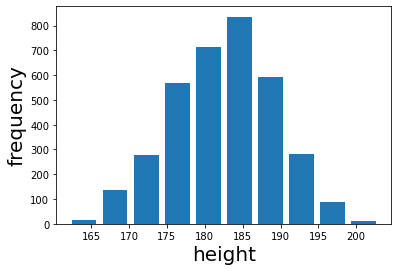

In [6]:
heights = [player['height'] for player in player_id2player.values() if player['height'] > 0]
plt.hist(heights, rwidth=0.8)
plt.xlabel('height', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.show()

### 4.B. <a id='competitions'>Competitions</a>

In [7]:
first_competition = list(competition_id2competition.keys())[0]
competition_id2competition[first_competition]

{'name': 'Italian first division',
 'wyId': 524,
 'format': 'Domestic league',
 'area': {'name': 'Italy',
  'id': '380',
  'alpha3code': 'ITA',
  'alpha2code': 'IT'},
 'type': 'club'}

### 4.C. <a id='matches'>Matches</a>

In [8]:
a_match = list(match_id2match.keys())[0]
match_id2match[a_match]#['teamsData'].keys()

{'status': 'Played',
 'roundId': 4406278,
 'gameweek': 38,
 'teamsData': {'3162': {'scoreET': 0,
   'coachId': 251025,
   'side': 'home',
   'teamId': 3162,
   'score': 2,
   'scoreP': 0,
   'hasFormation': 1,
   'formation': {'bench': [{'playerId': 4792,
      'ownGoals': '2',
      'redCards': '93',
      'goals': '0',
      'yellowCards': '0'},
     {'playerId': 20972,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 256479,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 241675,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 260250,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 69417,
      'ownGoals': '0',
      'redCards': '0',
      'goals': 'null',
      'yellowCards': '0'},
     {'playerId': 20460,
      'ownGoals':

### Count goals in a season

In [9]:
sum_goals = 0
for match_id, match in match_id2match.items():
    goals = match['label'].split(', ')[1].split(' - ')
    goals = [int(goal) for goal in goals]
    sum_goals += sum(goals)
sum_goals

1017

### Count average goals per match

In [10]:
goals_in_match = []
for match_id, match in match_id2match.items():
    goals = match['label'].split(', ')[1].split(' - ')
    goals = [int(goal) for goal in goals]
    goals_in_match.append(sum(goals))
round(np.mean(goals_in_match), 2)

2.68

### 4.D. <a id='events'>Events</a>

In [11]:
match_id2events[a_match][0]#[100]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 3344,
 'positions': [{'y': 50, 'x': 49}, {'y': 58, 'x': 38}],
 'matchId': 2576335,
 'eventName': 'Pass',
 'teamId': 3161,
 'matchPeriod': '1H',
 'eventSec': 2.4175900000000183,
 'subEventId': 85,
 'id': 253668302}

### List distinct combination of event types and subtypes

In [12]:
event_types = []
for match_id, events in match_id2events.items():
    for event in events:
        event_types.append((event['eventName'], event['subEventName']))
set(event_types)

{('Duel', 'Air duel'),
 ('Duel', 'Ground attacking duel'),
 ('Duel', 'Ground defending duel'),
 ('Duel', 'Ground loose ball duel'),
 ('Foul', 'Foul'),
 ('Foul', 'Hand foul'),
 ('Foul', 'Late card foul'),
 ('Foul', 'Out of game foul'),
 ('Foul', 'Protest'),
 ('Foul', 'Simulation'),
 ('Foul', 'Time lost foul'),
 ('Foul', 'Violent Foul'),
 ('Free Kick', 'Corner'),
 ('Free Kick', 'Free Kick'),
 ('Free Kick', 'Free kick cross'),
 ('Free Kick', 'Free kick shot'),
 ('Free Kick', 'Goal kick'),
 ('Free Kick', 'Penalty'),
 ('Free Kick', 'Throw in'),
 ('Goalkeeper leaving line', 'Goalkeeper leaving line'),
 ('Interruption', 'Ball out of the field'),
 ('Interruption', 'Whistle'),
 ('Offside', ''),
 ('Others on the ball', 'Acceleration'),
 ('Others on the ball', 'Clearance'),
 ('Others on the ball', 'Touch'),
 ('Pass', 'Cross'),
 ('Pass', 'Hand pass'),
 ('Pass', 'Head pass'),
 ('Pass', 'High pass'),
 ('Pass', 'Launch'),
 ('Pass', 'Simple pass'),
 ('Pass', 'Smart pass'),
 ('Save attempt', 'Reflexes'

## 5. <a id='basic_statistics'>Basic statistics</a>

### 5.A. <a id="frequency_by_type">Frequency of events per type</a>

For each event type, we plot how frequent it is in the events data set.

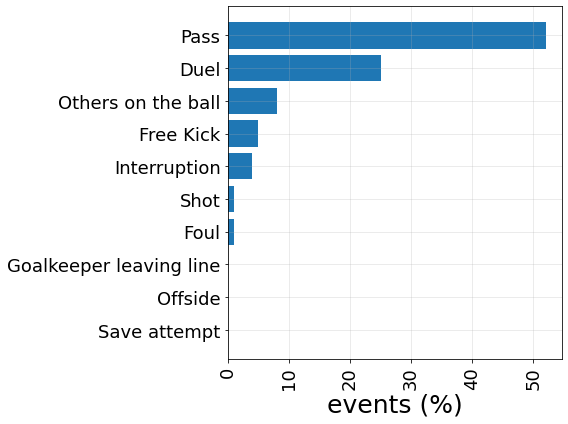

In [13]:
events_list = []
for match_id, events in match_id2events.items():
    for event in events:
        events_list.append(event['eventName'])

count = Counter(events_list)
# express frequency in percentage
counter = {}
for i, n_events in zip(count.keys(), count.values()):
    counter[i] = int(float(n_events)/len(events_list)*100)
sorted_d = np.array(sorted(counter.items(), key=operator.itemgetter(1), reverse=False))

#bar plot
fig, ax = plt.subplots(figsize=(8,6))
plt.barh(list(sorted_d[:,0]),[int(x) for x in list(sorted_d[:,1])])
plt.xticks(rotation=90);plt.xticks(fontsize=18)
plt.xlabel('events (%)', fontsize=25)
plt.yticks(fontsize=18)
plt.grid(alpha=0.3)
fig.tight_layout()
plt.show()

### 5.B. <a id='events_per_match'>Distribution of the number of events per match</a>
We compute the number of events in each match. We then plot the distribution of this quantity.

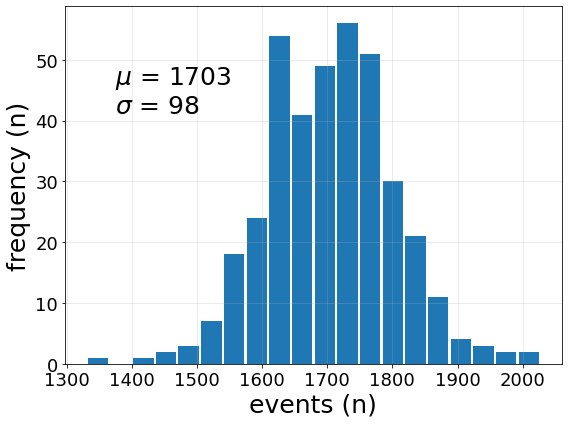

In [14]:
values = [len(events) for events in match_id2events.values()]
avg_n_events = np.mean(values)
std_n_events = np.std(values)

fig, ax = plt.subplots(figsize=(8,6))
plt.hist(values, rwidth=0.9, bins=20)
plt.grid(alpha=0.3)
plt.yticks(fontsize=18)
plt.xlabel('events (n)', fontsize=25)
plt.ylabel('frequency (n)', fontsize=25)
plt.xticks(fontsize=18)
plt.text(0.1, 0.7, 
         '$\mu$ = %i\n$\sigma$ = %i'%(avg_n_events, std_n_events), 
         fontsize=25, transform=ax.transAxes)
fig.tight_layout()
plt.show()

## 6. <a id='plot_events_on_field'>Plot events on the field</a>
We take an examplar match and plot on a soccer field all the events of the two teams. Each event is plotted on the position of the field where it has occurred.

In [15]:
match_id = 2576335 # a single match in Italy
match_events = match_id2events[match_id]
match_label = match_id2match[match_id]['label']
            
match_df = pd.DataFrame(match_events)
match_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3344,"[{'y': 50, 'x': 49}, {'y': 58, 'x': 38}]",2576335,Pass,3161,1H,2.417590,85,253668302
1,8,Simple pass,[{'id': 1801}],116349,"[{'y': 58, 'x': 38}, {'y': 91, 'x': 37}]",2576335,Pass,3161,1H,3.904412,85,253668303
2,8,Simple pass,[{'id': 1801}],135903,"[{'y': 91, 'x': 37}, {'y': 72, 'x': 34}]",2576335,Pass,3161,1H,6.484211,85,253668304
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306
4,8,Simple pass,[{'id': 1801}],21094,"[{'y': 14, 'x': 36}, {'y': 39, 'x': 30}]",2576335,Pass,3161,1H,14.032070,85,253668308


In [16]:
match_df['x_start'] = [x[0]['x'] for x in match_df['positions']]
match_df['y_start'] = [x[0]['y'] for x in match_df['positions']]
match_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,x_start,y_start
0,8,Simple pass,[{'id': 1801}],3344,"[{'y': 50, 'x': 49}, {'y': 58, 'x': 38}]",2576335,Pass,3161,1H,2.417590,85,253668302,49,50
1,8,Simple pass,[{'id': 1801}],116349,"[{'y': 58, 'x': 38}, {'y': 91, 'x': 37}]",2576335,Pass,3161,1H,3.904412,85,253668303,38,58
2,8,Simple pass,[{'id': 1801}],135903,"[{'y': 91, 'x': 37}, {'y': 72, 'x': 34}]",2576335,Pass,3161,1H,6.484211,85,253668304,37,91
3,8,Simple pass,[{'id': 1801}],138408,"[{'y': 72, 'x': 34}, {'y': 14, 'x': 36}]",2576335,Pass,3161,1H,10.043835,85,253668306,34,72
4,8,Simple pass,[{'id': 1801}],21094,"[{'y': 14, 'x': 36}, {'y': 39, 'x': 30}]",2576335,Pass,3161,1H,14.032070,85,253668308,36,14


### 6.A. <a id='static_plot'>Static plot</a>

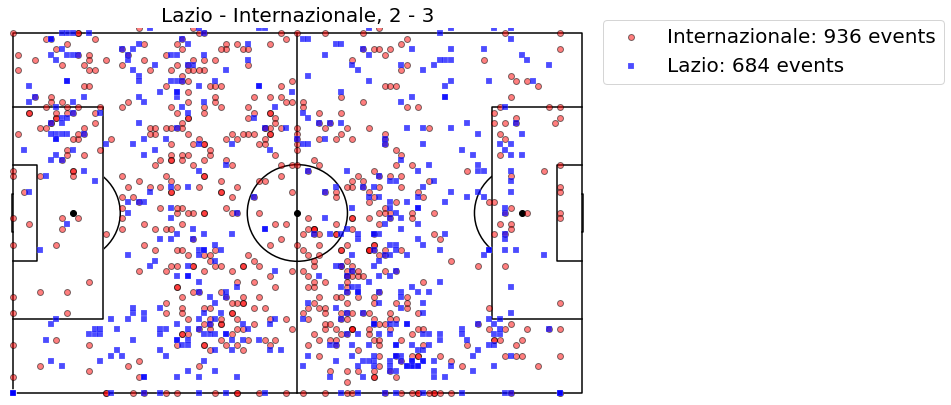

In [17]:
team_1, team_2 = np.unique(match_df['teamId'])
df_team_1 = match_df[match_df['teamId'] == team_1]
df_team_2 = match_df[match_df['teamId'] == team_2]

f = draw_pitch("white", "black", "h", "full")
plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s events' %(team_id2team[team_1]['name'], len(df_team_1)))
plt.scatter(df_team_2['x_start'], df_team_2['y_start'], marker='s', c='blue', edgecolors="w", linewidth=0.25, zorder=12, 
            alpha=0.7, label='%s: %s events' %(team_id2team[team_2]['name'], len(df_team_2)))
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
plt.title(match_label, fontsize=20)
plt.show()

In [18]:
def plot_events(match_id=2576335, team_id='both', event_name='all'):
    """
    Plot the events onthe position where they have been generated.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    team_id : str or int, optional
        the identifier of the team to plot. 
        If 'both', it indicates to plot both teams The default is 'both'.
        
    event_name : str, optional
        the type of the event to plot. If 'all', it plots all the events.
        The defauult is 'all'.
    """
    match_label = match_id2match[match_id]['label']
    match_events = match_id2events[match_id]
    selected_events = []
    for event in match_events:
        if team_id == 'both' or event['teamId'] == team_id:
            if event_name == 'all' or event['eventName'] == event_name:
                selected_events.append(event)
    
    match_df = pd.DataFrame(selected_events)
    match_df['x_start'] = [x[0]['x'] for x in match_df['positions']]
    match_df['y_start'] = [x[0]['y'] for x in match_df['positions']]
    
    if team_id == 'both':
        team_1, team_2 = np.unique(match_df['teamId'])
        df_team_1 = match_df[match_df['teamId'] == team_1]
        df_team_2 = match_df[match_df['teamId'] == team_2]
    else:
        df_team = match_df[match_df['teamId'] == team_id]
    
    f = draw_pitch("white", "black", "h", "full")
    if team_id == 'both':
        plt.scatter(df_team_1['x_start'], df_team_1['y_start'], c='red', edgecolors="k", zorder=12, 
            alpha=0.5, label='%s: %s %s' %(team_id2team[team_1]['name'], len(df_team_1), 'events' if event_name=='all' else event_name))
        plt.scatter(df_team_2['x_start'], df_team_2['y_start'], marker='s', c='blue', edgecolors="w", linewidth=0.25, zorder=12, 
                    alpha=0.7, label='%s: %s %s' %(team_id2team[team_2]['name'], len(df_team_2), 'events' if event_name=='all' else event_name))
        plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
    else:
        plt.scatter(df_team['x_start'], df_team['y_start'], 
                    c='red', edgecolors="k", zorder=12, alpha=0.5,
                   label='%s: %s %s' %(team_id2team[team_id]['name'], len(df_team), 'events' if event_name=='all' else event_name))
    plt.title(match_label, fontsize=20)
    plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1.05))
    plt.show()
 

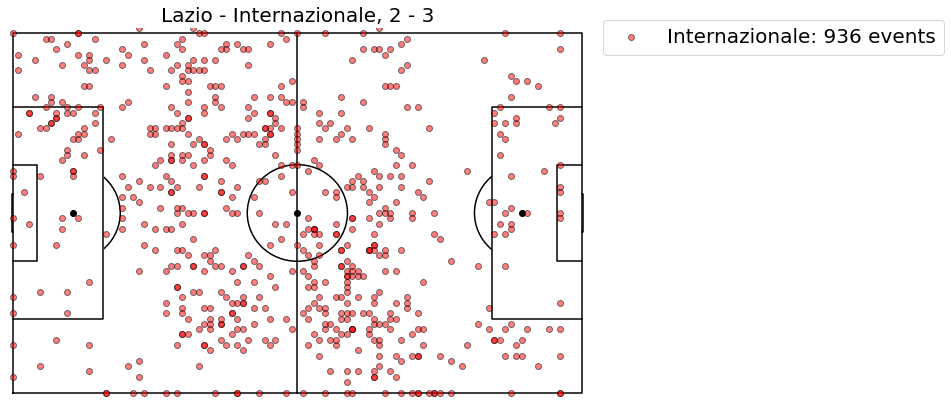

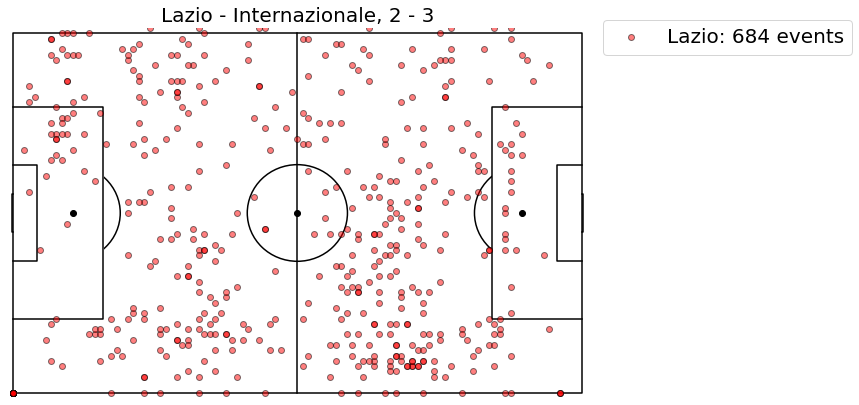

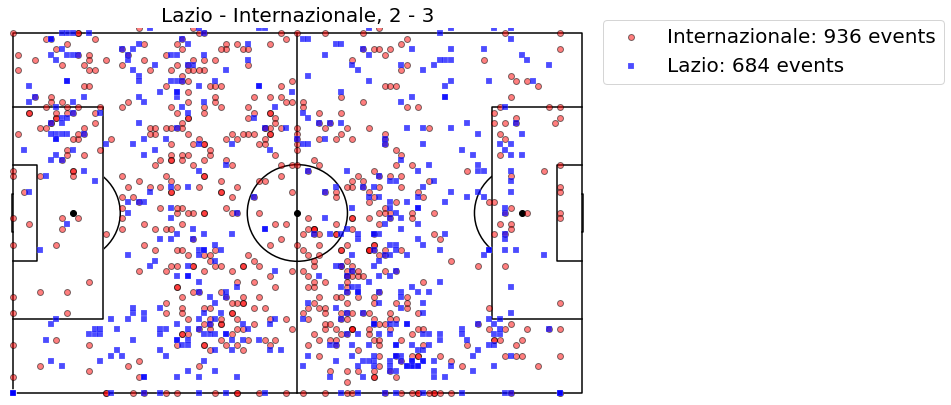

In [19]:
match_id, team1, team2 = 2576335, 3161, 3162
plot_events(team_id=3161)
plot_events(team_id=3162)
plot_events(team_id='both')

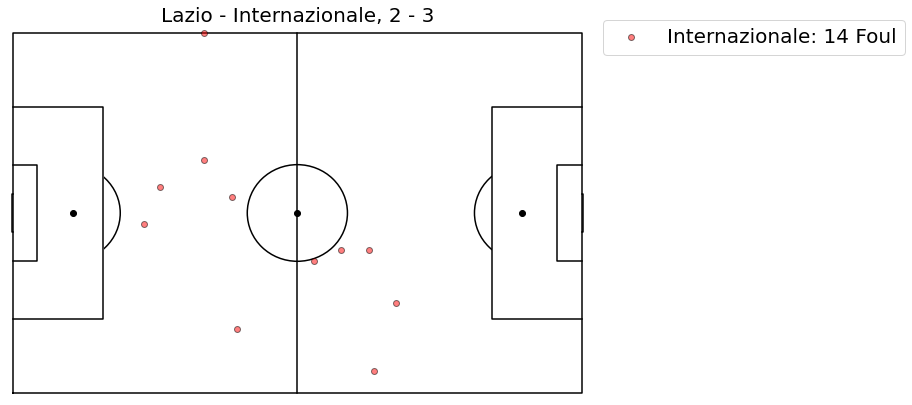

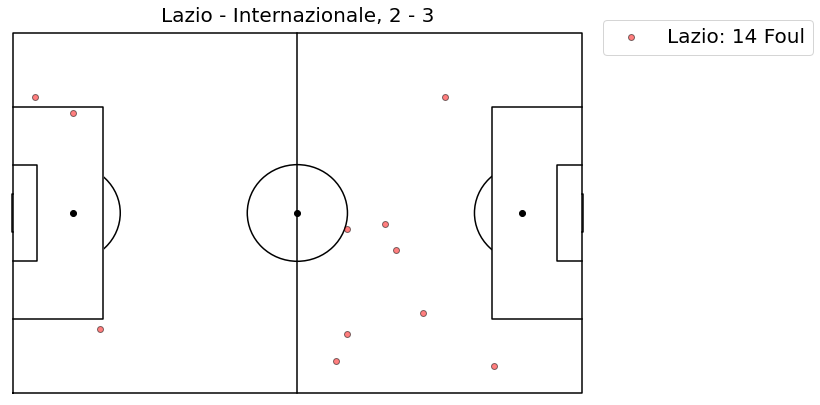

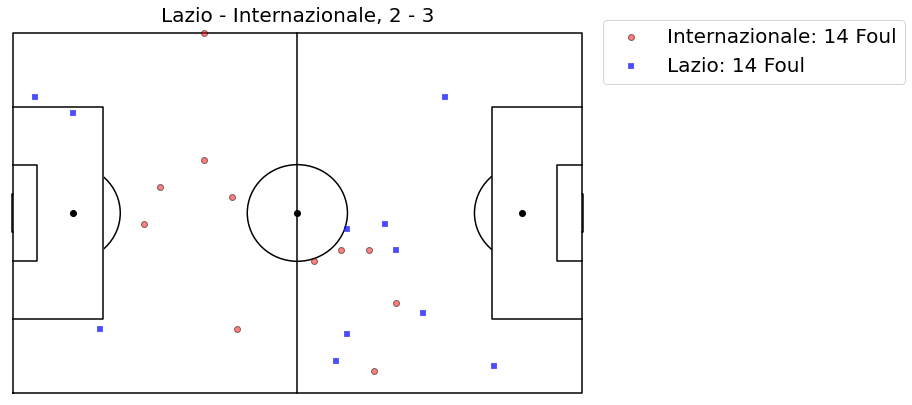

In [20]:
match_id, team1, team2, event_name = 2576335, 3161, 3162, 'Foul'
plot_events(team_id=3161, event_name=event_name)
plot_events(team_id=3162, event_name=event_name)
plot_events(team_id='both', event_name=event_name)

### 6.B. <a id='interactive_plot'>Interactive plot</a>

In [21]:
def visualize_events(match_id=2576335, team_id='both', event_name='all'):
    """
    Visualize all the events of a match on the soccer pitch.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    team_id : str or int, optional
        the identifier of the team to plot. 
        If 'both', it indicates to plot both teams The default is 'both'.
        
    event_name : str, optional
        the type of the event to plot. If 'all', it plots all the events.
        The defauult is 'all'.
    """
    
    match_events = []
    for event in match_id2events[match_id]:
        if team_id == 'both' or event['teamId'] == team_id:
            if event_name == 'all' or event['eventName'] == event_name:
                match_events.append(event)
    
    match = match_id2match[match_id] 
    match_label = match['label']
    
    team1, team2 = match['teamsData'].keys()
    team_name1, team_name2 = team_id2team[int(team1)]['name'], team_id2team[int(team2)]['name']
    
    # Create and style traces
    trace1 = go.Scatter(
        x = [event['positions'][0]['x'] for event in match_events if str(event['teamId']) == team1],
        y = [event['positions'][0]['y'] for event in match_events if str(event['teamId']) == team1],
        text = ['%s by %s' %(event['eventName'], player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')) for event in match_events if str(event['teamId']) == team1],
        mode = 'markers',
        name = team_name1,
        marker = dict(
            size = 8,
            color = 'red',
        )
    )

    trace2 = go.Scatter(
        x = [event['positions'][0]['x'] for event in match_events if str(event['teamId']) == team2],
        y = [event['positions'][0]['y'] for event in match_events if str(event['teamId']) == team2],
        text = ['%s by %s' %(event['eventName'], player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')) for event in match_events if str(event['teamId']) == team2],
        mode = 'markers',
        name = team_name2,
        marker = dict(
            size = 8,
            color = 'blue',
            symbol='square'
        )
    )

    fig = dict(data=[trace1, trace2], layout=get_pitch_layout(match_label))
    fig['data'][0]['name'] = team_name1
    fig['data'][1]['name'] = team_name2
    iplot(fig)

In [22]:
visualize_events(event_name='Pass')

In [23]:
visualize_events(event_name='Foul')

## 7. <a id='spatial_distribution_events'>Spatial distribution of events</a>

Distribution of positions per event type. Kernel density plots showing the distribution of the events’ positions during match. The darker is the green, the higher is the number of events in a specific field zone.

In [24]:
def plot_kde_events_on_field(sample_size=10000):
    """
    Generate density plots on the field for each event type
    
    Parameters
    ----------
    sample_size: int
        random sample of values to use (default: 10000). The code becomes slow is you increase this value
        significantly.
    """
    positions = []
    for match_events in match_id2events.values():
        for event in match_events:
            positions.append([event['eventName'], 
                              event['positions'][0]['x'], 
                              event['positions'][0]['y']])

    positions_df = pd.DataFrame(positions, columns=['eventName','x','y'])

    for event_type in EVENT_TYPES:
        pos_event_df = positions_df[positions_df['eventName'] == event_type]
        fig, ax = pitch()
        if len(pos_event_df) >= sample_size:
            x_y = pos_event_df[['x','y']].sample(sample_size).astype(float)
        else:
            x_y = pos_event_df[['x','y']].astype(float)
        
        sns.kdeplot(x_y['x'], x_y['y'], cmap = 'Greens', shade = True)
        
        plt.title(event_type, fontsize = 30)
        plt.xlim(-1,101)
        plt.ylim(-1,101)
        plt.axis('off')
        fig.tight_layout()
        plt.show()

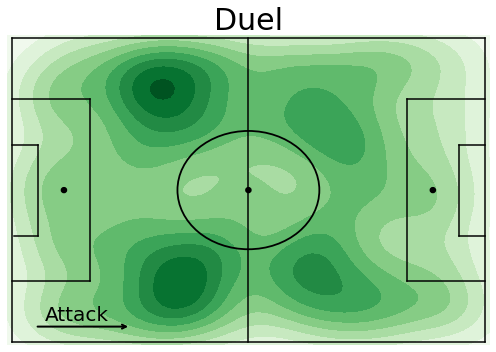

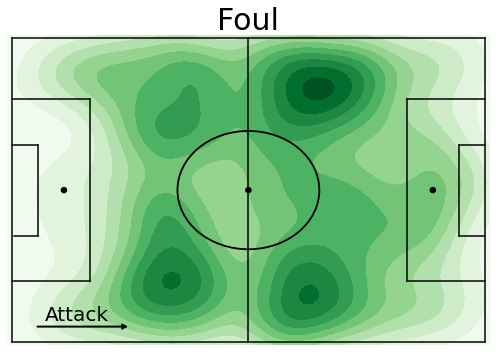

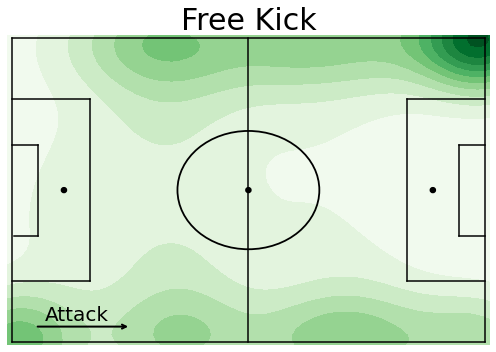

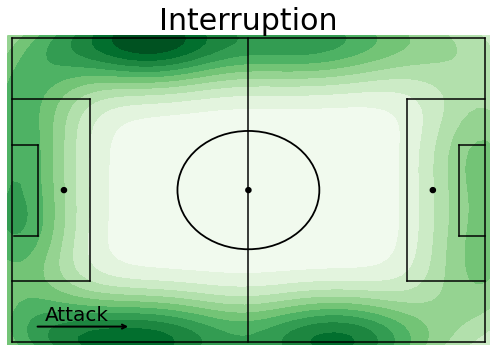

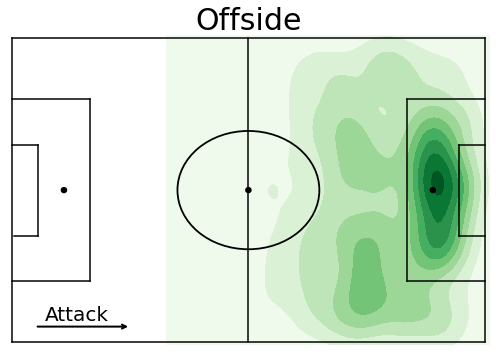

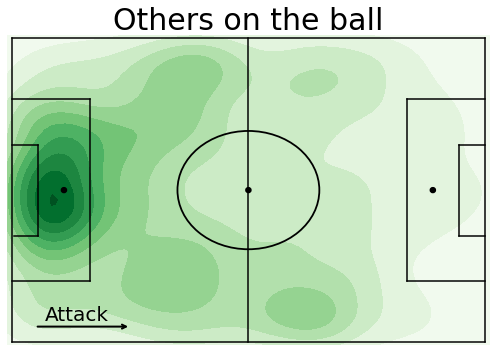

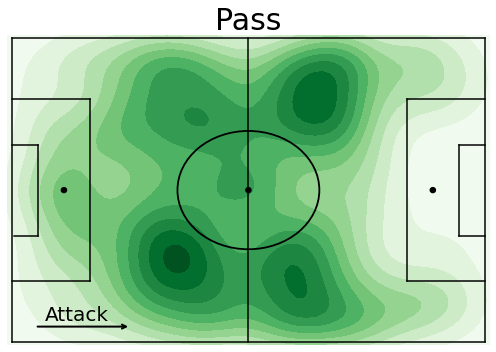

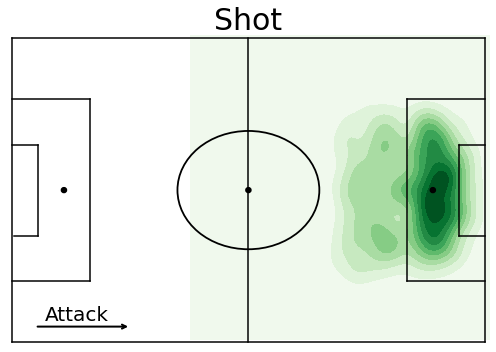

In [25]:
plot_kde_events_on_field(sample_size=1000)

## 8. <a id='intra_match_evolution'>Intra-match evolution of the events</a>

In-match evolution of the number of events. Number of events (e.g., goals on the top plot, yellow cards
in the middle plot and the red cards in the bottom plot) that occur in all the matches in the data set, with time
windows of 5 minutes.

In [26]:
def in_match_evolution(event_name='Goal', event_tag=101):
    """
    Plot the in-match evolution of the number of events of a specific type.
    
    Parameters
    ----------
    event_name : str, optional
        the type of event to plot. The default is "Goal".
        
    event_tag : int, optional
        the type of tag to plot. The default is 101.
    """
    # slect specific event in accordance with event_tag
    events_time = []
    for match_id, match_events in match_id2events.items():
        for event in match_events:
            tags = event['tags']
            for tag in tags:
                if tag['id'] == event_tag:
                    events_time.append([event['matchId'], 
                                        event['matchPeriod'], 
                                        event['eventSec']])
                
    # let us convert it into a DataFrame
    event_df = pd.DataFrame(events_time, columns=['matchId','matchPeriod','eventSec'])
    
    # create figure
    fig, ax = plt.subplots(figsize=(8,6))
    
    start_bin_2h = 11
    
    # define plot characteristics for 1H e 2H
    for half, color_bar in zip(['1H','2H'],['blue','green']):
        
        # define DataFrame per half time
        df_half = event_df[event_df['matchPeriod'] == half].sort_values(['matchPeriod','eventSec'])
        
        # create bins every 5 minutes
        df_half['binned'] = df_half['eventSec'].pipe(lambda x: pd.to_timedelta(x, "s")).dt.floor("5min").astype("category").cat.codes
        
        # merge bins up to 45 minutes 
        df_half['binned'] = [9 if x>9 else x for x in df_half['binned']]
        
        # plot bin for second half
        if half == '2H':
            df_half['binned'] = [x+start_bin_2h for x in df_half['binned']]
            
        # barplot
        count = Counter(df_half.binned)
        barlist = plt.bar(count.keys(),count.values(),
                          label=half,color=color_bar)
        
    plt.legend(loc=2, fontsize=15, frameon=True, shadow=True)
    plt.xticks(list(range(0,23)),['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40','40-45','>45','',
                                  '45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','>90'],
              rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    max_count_value = np.max(list(count.values()))
    plt.text(9.65, max_count_value-(max_count_value/100*10), 'half time', rotation=90, 
             bbox=dict(facecolor='w',edgecolor='r'),
             verticalalignment='center', horizontalalignment='left', fontsize=15, 
             color='tomato')
    plt.vlines(10, 0, max_count_value+(max_count_value/100*10),colors='r',alpha=0.5)
    plt.ylim(0,max_count_value+(max_count_value/100*10))
    plt.xlabel('match time (min)', fontsize=25)
    plt.ylabel('%s (n)'%event_name, fontsize=25)
    plt.grid(alpha=0.3)
    fig.tight_layout()
    plt.show()

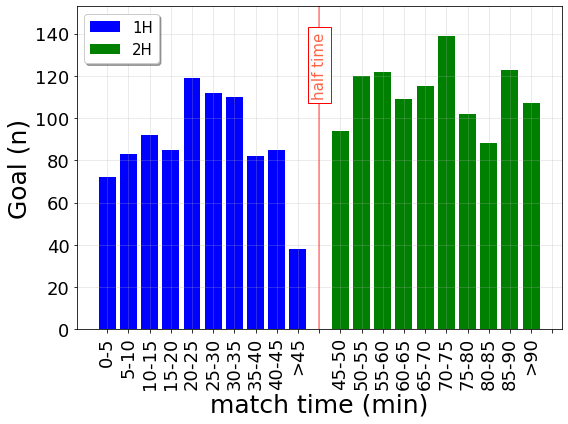

In [27]:
in_match_evolution(event_name='Goal', event_tag=101)

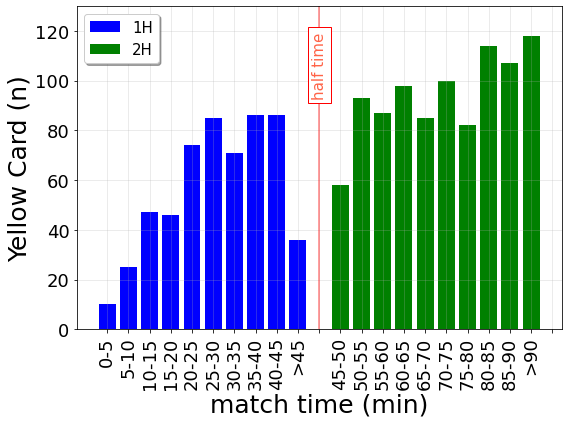

In [28]:
in_match_evolution(event_name='Yellow Card', event_tag=1702)

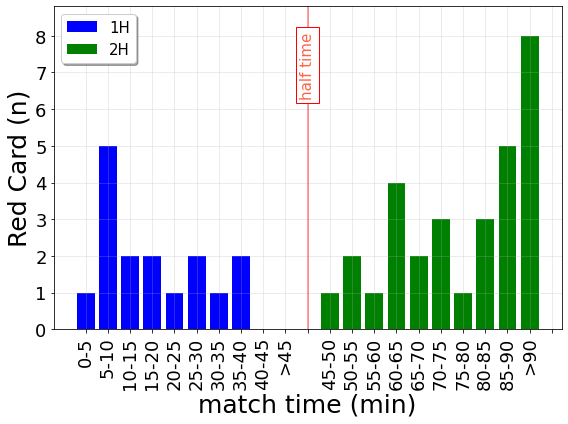

In [29]:
in_match_evolution(event_name='Red Card', event_tag=1701)

## 9. <a id='advanced_statistics'>Advanced Statistics</a>

## 9.A. <a id='invasion_acceleration_index'>Invasion index and acceleration index</a>

Invasion index and acceleration index for a game in the match data set. Bold lines represent the rolling mean of, respectively, invasion index (a) and acceleration index (b), while thin lines represent the individual values computed for each possession phase of each team. Purple vertical lines refer to the two goal scored by Fiorentina during the match, while the red vertical line indicates the half time of the match.

A team’s invasion index during a game can be computed with a simple algorithm:

- Split the match into possession phases, i.e., sequence of consecutive events on the ball generated by the team;
- for each possession phase of the team, **take the event with the highest weight**. An event's weight is computed as its “dangerousness”, i.e., the probability to score from the position where the event occurs. The dangerousness of a position is computed according to the schema in the figure below;
- compute the sum of all the weights obtained for the team during the game.

![Dangerousity](dangerousity.jpg "Dangerousity")
Dangerousness of each zone of in the opponent’s area. Every zone is associated with a value of dangerousness according to the probability of scoring from that zone.

```
D. Link and H. Weber, Using individual ball possession as a performance indicator in soccer, workshop on Large-Scale Sports Analytics, 2015.
http://bit.ly/2xuckCi
```

The average acceleration is an estimate of how fast a team is on reaching the most dangerous position during a possession phase. 

A team's average acceleration during a game is computed as follows:

- For each possession phase, take the position of the first event $e_1$ and the position of the event associated with the most dangerous position $e_{max}$;
- compute the time difference $delta_t = t(e_{max})$ - $t(e_1)$;
- compute the ratio between the invasion index of the possession phase and the square of $delta_t$.

In [30]:
def get_invasion_index(match_id2events, match_id=2576263):
    """
    Compute the invasion index for the input match
    
    Parameters
    ----------
    match_id2events : dict
        dictionary of match identifiers to list of events in the match.
    
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        a tuple of two dictionaries of teams to invasion index and invasion speed, 
        respectively
    """
    # split the match into possession phases (actions)
    actions = get_play_actions(match_id2events, match_id)
    
    # initialize the dictionaries containing the invasion and acceleration indeces
    team2invasion_index = defaultdict(list)
    team2invasion_speed = defaultdict(list)
    
    # take all events of the match
    events_match = match_id2events[match_id]
    
    # sort matches by time and half
    half_offset = {'2H': max([x['eventSec'] for x in events_match if x['matchPeriod']=='1H']),
                   '1H':0}
    
    ## A COSA SERVE QUESTA RIGA DI CODICE SE POI VIENE SOVRASCRITTA NEL CICLO FOR SOTTO?
    events_match = sorted(events_match, key = lambda x: x['eventSec'] + half_offset[x['matchPeriod']])
    
    off = half_offset['2H']
    # for each action in the match
    for action in actions:
        action_type, events_match = action
        team_id = events_match[0]['teamId']
        
        offset = off if events_match[0]['matchPeriod']=='2H' else 0
        if len(set([x['matchPeriod'] for x in events_match])) > 1:
            continue
        
        weights, times = [], []
        for event in events_match:
            try:
                x, y = int(event['positions'][0]['x']), int(event['positions'][0]['y'])
                event_time = event['eventSec']
            except:
                continue #skip to next event in case of missing position data
            weights.append(get_weight((x, y)))
            times.append(event_time)
        
        # sort weights by time
        time_max_invasion = sorted(times, key=lambda x: weights[times.index(x)], reverse=True)[0]
        event_0 = events_match[0]['eventSec']
        delta_t = time_max_invasion - event_0
        if delta_t > 0.8: ## WHAT'S THIS NUMBER?
            invasion_speed = (events_match[0]['eventSec'] + offset, (np.max(weights) - weights[0])/delta_t**2) 
            team2invasion_speed[team_id].append(invasion_speed)
        
        # add invasion index of current action
        invasion_index = (events_match[0]['eventSec'] + offset, np.max(weights))
        team2invasion_index[team_id].append(invasion_index)
    
    return team2invasion_index, team2invasion_speed, match_label

In [31]:
team2inv_index, team2inv_speed, match_label = get_invasion_index(match_id2events,
                                                                 match_id=2576263)

INVASION INDEX
AS Roma 0.23 0.31
ACF Fiorentina 0.27 0.33

ACCELERATION INDEX
AS Roma 0.06 0.17
ACF Fiorentina 0.07 0.15


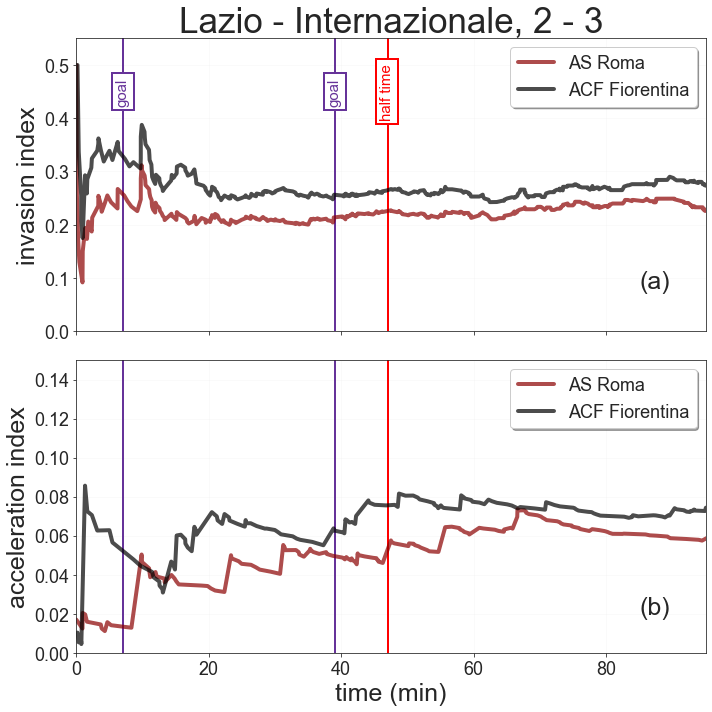

In [32]:
plot_invasion_and_acceleration_index(match_label, team2inv_index, team2inv_speed)

## 9.B. <a id="passing_networks">Passing networks</a>
A player passing network is a weighted network where nodes are players and weighted edges represent movements of the ball between players.

In soccer-logs we do not have direct information about the destination player, i.e., the player to which the pass is directed. We infer this information by sorting all the events and looking at the outcome of each pass event. If the pass event of player $u_1$ of team $A$ is accurate and the next event   is by a teammate $u_2$, we assume that player $u_2$ is the destination player of the pass.

```
Cintia et al., The harsh rule of the goals: data-driven performance indicators for football teams, In Proceedings of the 2015 IEEE International Conference on Data Science and Advanced Analytics (DSAA'2015), 2015, https://ieeexplore.ieee.org/document/7344823.
```

In [33]:
def passing_networks(match_id=2576105):
    """
    Construct the passing networks of the teams in the match.
    
    Parameters
    ----------
    match_id : int, optional
        identifier of the match to plot
        
    Returns
    -------
    tuple
        the two constructed networks, as networkx objects.
    """
    
    # take the names of the two teams of the match
    match_label = match_id2match[match_id]['label']
    team1_name = match_label.split('-')[0].split(' ')[0]
    team2_name = match_label.split('-')[1].split(' ')[1].split(',')[0]
    
    # take all the events of the match
    match_events = []
    for event in match_id2events[match_id]:
        if event['eventName'] == 'Pass':
            match_events.append(event)

    match_events_df = pd.DataFrame(match_events)
    first_half_max_duration = np.max(match_events_df[match_events_df['matchPeriod'] == '1H']['eventSec'])

    # sum 1H time end to all the time in 2H
    for event in match_events:
        if event['matchPeriod'] == '2H':
            event['eventSec'] += first_half_max_duration
    
    team2pass2weight = defaultdict(lambda: defaultdict(int))
    for event, next_event, next_next_event in zip(match_events, match_events[1:], match_events[2:]):
        try:
            if event['eventName'] == 'Pass' and ACCURATE_PASS in [tag['id'] for tag in event['tags']]:
                sender = player_id2player[event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                # case of duel
                if next_event['eventName'] == 'Duel':
                    # if the next event of from a playero of the same tema
                    if next_event['teamId'] == event['teamId']:
                        receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                    else:
                        receiver = player_id2player[next_next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
                else:  # any other event 
                    if next_event['teamId'] == event['teamId']:
                        receiver = player_id2player[next_event['playerId']]['shortName'].encode('ascii', 'strict').decode('unicode-escape')
                        team2pass2weight[team_id2team[event['teamId']]['name']][(sender, receiver)] += 1
        except KeyError:
            pass
    # crete networkx graphs
    G1, G2 = nx.DiGraph(team=team1_name), nx.DiGraph(team=team2_name)
    for (sender, receiver), weight in team2pass2weight[team1_name].items():
        G1.add_edge(sender, receiver, weight=weight)
    for (sender, receiver), weight in team2pass2weight[team2_name].items():
        G2.add_edge(sender, receiver, weight=weight)    
    
    return G1, G2

In [34]:
def plot_passing_networks(G1, G2):
    """
    Plot the two passing networks in input.
    
    Parameters
    ----------
    G1 : networkx object
        the object representing the first network
        
    G2 : networkx object
        the object representing the second network
    """
    pos1 = nx.spring_layout(G1, 4)
    pos2 = nx.spring_layout(G2, 4)
    nome2degree = dict(G1.degree)
    nx.draw(G1, pos=pos1, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()], 
            node_color='red', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()
    
    nome2degree = dict(G2.degree)
    nx.draw(G2, pos=pos2, nodelist=list(nome2degree.keys()), 
            node_size=[deg * 50 for deg in nome2degree.values()],
            node_color='blue', edge_color='black',
            with_labels=True, font_weight='bold', alpha=0.75)
    plt.show()

In [35]:
G1, G2 = passing_networks(match_id=2576105)

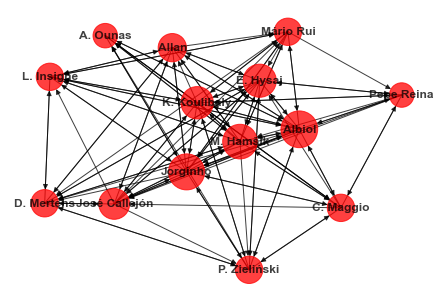

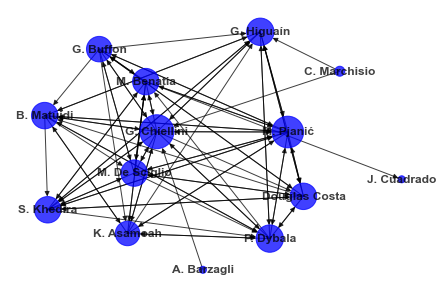

In [36]:
plot_passing_networks(G1, G2)

### 9.B. <a id='flow_centrality'>Flow centrality</a>

The **flow centrality** captures the fraction of times that a player intervenes in those paths that result in a shot. We take into account defensive efficiency by letting each player start a number of paths proportional to the number of balls that he recovers during the match.

```
Duch et al., Quantifying the Performance of Individual Players in a Team Activity, PLoS ONE 5(6): e10937. https://doi.org/10.1371/journal.pone.00109372010https://doi.org/10.1371/journal.pone.0010937
```

### Distribution of the flow centrality

In [37]:
def get_players_flow_centrality():
    """
    Compute the sequence of flow centralities for each player.
        
    Returns
    -------
    dict
        a dictionary of player names to a list of flow centralities
        (one per each match played by the player).
    """
    player2centralities = defaultdict(list)
    for match in tqdm(match_id2match.values()):
        match_id = match['wyId']
        G1, G2 = passing_networks(match_id=match_id)
        if G1.number_of_nodes() > 0:
            for player_name in G1.nodes():
                G1 = G1.to_undirected()
                if nx.is_connected(G1):
                    flow_centrality = nx.current_flow_betweenness_centrality(G1)[player_name]
                    player2centralities[player_name].append(flow_centrality)
        if G2.number_of_nodes() > 0:
            for player_name in G2.nodes():
                G2 = G2.to_undirected()
                if nx.is_connected(G2):
                    flow_centrality = nx.current_flow_betweenness_centrality(G2)[player_name]
                    player2centralities[player_name].append(flow_centrality)
    return player2centralities

In [38]:
player2centralities = get_players_flow_centrality()

100%|██████████| 380/380 [02:59<00:00,  2.11it/s]


In [39]:
chiellini_fcs = player2centralities['G. Chiellini']
immobile_fcs = player2centralities['C. Immobile']
barella_fcs = player2centralities['N. Barella']

In [40]:
def plot_flow_centrality(players_centralities, names):
    """
    Plot the flow centralities in time of the players.
    
    Parameters
    ----------
    players_centralities : list of lists
        the list of the list of flow centralities of the player
        
    names : list
        the list of players
    """
    sns.set_style('ticks')

    f,ax = plt.subplots(figsize=(10,5))
    for player_centralities, player_name in zip(players_centralities, names):
        sns.kdeplot(pd.DataFrame(player_centralities, columns=['flow centrality'])['flow centrality'], 
                    shade=True, label=player_name)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('flow centrality', fontsize=25)
    plt.ylabel('p(flow centrality)', fontsize=25)
    lab = ax.legend(loc=1,fontsize=18,frameon=True,shadow=True)
    f.tight_layout()
    plt.show()

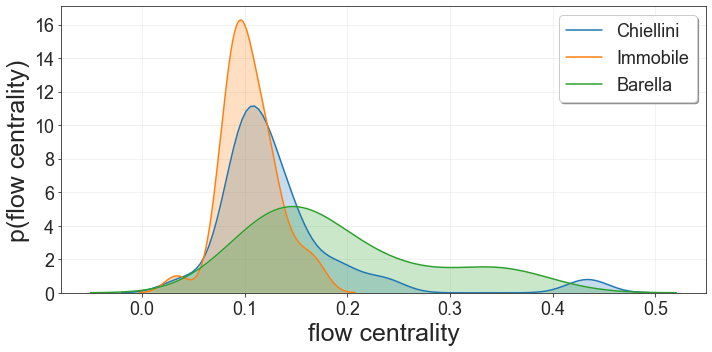

In [41]:
plot_flow_centrality([chiellini_fcs, immobile_fcs, barella_fcs], 
                     ['Chiellini', 'Immobile', 'Barella'])

## 9.C <a id='playerank'>PlayeRank</a>

PlayeRank is a data-driven framework to evaluate the performance of soccer players, designed to work with match events. The PlayeRank framework consists of four main components:
<ol type="a">
	<li>match events database</li>
	<li>learning module</li>
	<li>rating module</li>
	<li>ranking module</li>
</ol>

![PlayeRank framework schema](https://raw.githubusercontent.com/mesosbrodleto/playerank/master/playerank_schema_tist.png)

**Schema of the PlayeRank framework**. Starting from a database of match events **(a)**, it consists of three main phases. The learning phase **(c)** is an "online" procedure: It must be executed at least once before the other phases, since it generates information used in the other two phases, but then it can be updated separately. The rating **(b)** and the ranking phases **(d)** are online procedures, i.e., they are executed every time anew match is available in the database of match events. 

An exhaustive description of PlayeRank framework is available in this paper:
```
Pappalardo, Luca, Cintia, Paolo, Ferragina, Paolo, Massucco, Emanuele, Pedreschi, Dino & Giannotti, Fosca (2019) PlayeRank: Data-driven Performance Evaluation and Player Ranking in Soccer via a Machine Learning Approach. ACM Transactions on Intelligent Systems and Technologies 10(5), DOI:https://doi.org/10.1145/3343172
```

To build player rankings from match events, the following steps are required:

1. compute feature weights (learning)
2. compute roles (learning)
3. compute performance scores (rating)
4. aggregate performance scores (ranking)

More details on our github repository: https://github.com/mesosbrodleto/playerank

In [42]:
#!git clone https://github.com/mesosbrodleto/playerank.git
#!python playerank/playerank/setup.py install 

Clone in 'playerank' in corso...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 249 (delta 3), reused 6 (delta 2), pack-reused 237
Ricezione degli oggetti: 100% (249/249), 698.54 KiB | 1.77 MiB/s, fatto.
Risoluzione dei delta: 100% (136/136), fatto.
/Users/jonpappalord/anaconda3/envs/soccerenv/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'install_requires'
  warnings.warn(msg)
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/playerank
copying playerank/__init__.py -> build/lib/playerank
copying playerank/data_download.py -> build/lib/playerank
running install_lib
creating /Users/jonpappalord/anaconda3/envs/soccerenv/lib/python3.7/site-packages/playerank
copying build/lib/playerank/__init__.py -> /Users/jonpappalord/anaconda3/envs/soccerenv/lib/python3.7/site-packages/playerank
copying build/lib/playeran

### Learning phase

Here we create Features weight and Role detector. The following blocks store the results on two configuration files: *feature_weights.json* and *role_matrix.json*. We already provide such files, you can skip the execution of the learning blocks. 

#### features weight

We aggregate QualityFeatures and goal scored by team and matches. Features weight will be stored into a json file, to be used for performance scores computation.

*QualityFeatures* are all the events with their corresponding outcomes. 

Example of quality feature:

```{
'match':  111,
'feature': 'Pass-Simple Pass-accurate',
'entity': 3890, 
'value': 400
}```



On learning phase, the `entity` for quality features is the team, while the value is the number of `feature` events observed for team in `match`

*GoalScoredFeatures* are the goals difference for a team in a match.
Example of GoalScored feature:


```{ 'match': 111, 'feature': 'goal-scored', 'entity': 3159, 'value': -2 }```

In this case, `entity` 3159  lost `match` 111 with a goals diffence of 2. (e.g. 0-2, 1-3, ...)

In [45]:
from playerank.playerank.features import qualityFeatures,relativeAggregation,goalScoredFeatures
from playerank.playerank.models import Weighter


qualityFeat = qualityFeatures.qualityFeatures()
quality = qualityFeat.createFeature(events_path = 'data/events',
                        players_file='data/players.json' ,entity = 'team')
gs = goalScoredFeatures.goalScoredFeatures()
goals = gs.createFeature('data/matches')

#merging of quality features and goals scored
aggregation = relativeAggregation.relativeAggregation()
aggregation.set_features([quality,goals])
df = aggregation.aggregate(to_dataframe = True)

weighter = Weighter.Weighter(label_type='w-dl')
output_path = "feature_weights.json"
weighter.fit(df, target = 'goal-scored',  var_threshold = 0.02, filename=output_path)
print ("features weights stored in %s"%output_path)

[qualityFeatures] added 632807 events from data/events/events_France.json
[qualityFeatures] added 628659 events from data/events/events_Spain.json
[qualityFeatures] added 519407 events from data/events/events_Germany.json
[qualityFeatures] added 78140 events from data/events/events_European_Championship.json
[qualityFeatures] added 101759 events from data/events/events_World_Cup.json
[qualityFeatures] added 647372 events from data/events/events_Italy.json
[qualityFeatures] added 643150 events from data/events/events_England.json
[GoalScored features] added 64 matches
[GoalScored features] added 380 matches
[GoalScored features] added 306 matches
[GoalScored features] added 380 matches
[GoalScored features] added 380 matches
[GoalScored features] added 380 matches
[GoalScored features] added 51 matches
[relativeAggregation] added 154945 features
[relativeAggregation] added 3882 features
[relativeAggregation] matches aggregated: 3882
[Weighter] filtered features: [('Pass-Hand pass-accura

#### roles matrix computation

A role matrix is a data structure where, given x and y (integer, between 0 and 100),
it contains the correspinding roles for a player having center of performance = x,y

The structure of role_matrix is: x->y->role

'kind' could be either 'multi' or 'single'. 'Multi' considers also hybrid roles, i.e. roles not definitely belonging to one single role. A player with an hybrid role has a center of performance that is in the edge between two roles (clusters). 

To compute roles, we create a new feature, named *centerOfPerformanceFeature*, in this format:

```{
'match':  111,
'feature': 'avg_x' | 'avg_y',
'entity': 3890, 
'value': 35.0
} ```

For each player, in each match, we compute both average x position and average y position. Then we aggregate it, in order to use them with a clustering function, that will results in the role detection module, stored into *role_matrix*. 


In [46]:
from playerank.playerank.features import centerOfPerformanceFeature, plainAggregation
from playerank.playerank.models import Clusterer
import pandas as pd
import json

#getting average position for each player in each match
centerfeat = centerOfPerformanceFeature.centerOfPerformanceFeature()
centerfeat = centerfeat.createFeature(events_path = 'data/events',
                    players_file='data/players.json')

#plain aggregation to get a dataframe
aggregation = plainAggregation.plainAggregation()
aggregation.set_features([centerfeat])
df = aggregation.aggregate(to_dataframe = True )

#use clustering object to get the best fit
clusterer = Clusterer.Clusterer(verbose=True, k_range=(8, 9))
clusterer.fit(df.entity, df.match, df[['avg_x', 'avg_y']], kind='single')

matrix_role = clusterer.get_clusters_matrix(kind = 'single') 

json.dump(matrix_role, open("role_matrix.json",'w'))


/Users/jonpappalord/anaconda3/envs/soccerenv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



[centerOfPerformanceFeature] added 632807 events from data/events/events_France.json
[centerOfPerformanceFeature] added 628659 events from data/events/events_Spain.json
[centerOfPerformanceFeature] added 519407 events from data/events/events_Germany.json
[centerOfPerformanceFeature] added 78140 events from data/events/events_European_Championship.json
[centerOfPerformanceFeature] added 101759 events from data/events/events_World_Cup.json
[centerOfPerformanceFeature] added 647372 events from data/events/events_Italy.json
[centerOfPerformanceFeature] added 643150 events from data/events/events_England.json
[plainAggregation] added 139398 features
[plainAggregation] matches aggregated: 46466
FITTING kmeans...

n_clust	|silhouette
---------------------
8	|0.4029
9	|0.3768
Best: n_clust=8 (silhouette=0.4029)

DONE.


### Features weight

In [47]:
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
import json

feature_data = json.load(open("feature_weights.json"))

fig = go.Figure([go.Bar(x=list(feature_data.keys()), y=list(feature_data.values()))])
py.iplot(fig)

### Role matrix

In [49]:
from collections import defaultdict

##we create a dictionary in the form: role->[list of points associated to the role]
role_points = defaultdict(list)

for x in matrix_role:
    for y in matrix_role[x]:
        role = matrix_role[x][y]
        role_points[role].append((x,y))
traces = []

for role in role_points:
    traces.append(go.Scatter(
              x=[x[0] for x in role_points[role]],
              y=[x[1] for x in role_points[role]],
              mode='markers',
              opacity=0.8,
              marker={
                  'size': 10,
                  'line': {'width': 0.1, 'color': 'white'}
              },
              name=role
          ))


fig = go.Figure( data = traces + [
                                go.Scatter(
                                    showlegend=False,
                                    y=[0, 100],
                                    x=[50, 50],
                                    mode='lines',
                                    line={'width': 2, 'color': 'white'}
                                ),
                                go.Scatter(
                                    showlegend=False,
                                    y=[20, 20, 80, 80],
                                    x=[0, 16, 16, 0],
                                    mode='lines',
                                    line={'width': 2, 'color': 'white'},
                                ),
                                go.Scatter(
                                    showlegend=False,
                                    y=[20, 20, 80, 80],
                                    x=[100, 84, 84, 100],
                                    mode='lines',
                                    line={'width': 2, 'color': 'white'}
                                ),
                                go.Scatter(
                                    showlegend=False,
                                    y=[35, 35, 65, 65],
                                    x=[100, 94, 94, 100],
                                    mode='lines',
                                    line={'width': 2, 'color': 'white'}
                                ),
                                go.Scatter(
                                    showlegend=False,
                                    y=[35, 35, 65, 65],
                                    x=[0, 6, 6, 0],
                                    mode='lines',
                                    line={'width': 2, 'color': 'white'}
                                ), ],

                            layout = 
                                go.Layout(
                                    hovermode='closest',
                                    autosize=True,
                                    width=550,
                                    height=400,
                                    plot_bgcolor='rgb(59,205,55)',
                                    xaxis={
                                        'range': [0, 100],
                                        'showgrid': False,
                                        'showticklabels': False,
                                    },
                                    yaxis={
                                        'range': [0, 100],
                                        'showgrid': False,
                                        'showticklabels': False,
                                    },
                                    shapes=[
                                        {
                                            'type': 'circle',
                                            'xref': 'x',
                                            'yref': 'y',
                                            'y0': 30,
                                            'x0': 35,
                                            'y1': 70,
                                            'x1': 65,
                                            'line': {
                                                'color': 'white',
                                            },
                                        }]) )
                                
py.iplot(fig)

### Playerank scores computation

Conversely to learning phase, we now compute quality features aggregating by player.

*QualityFeatures* are all the events with their corresponding outcomes. 

Example of quality feature:

``` 
{
'match':  111,
'feature': 'Pass-Simple Pass-accurate',
'entity': 311032, 
'value': 400
}
```







In this phase, the `entity` for quality features is the player, while the value is the number of `feature` events observed for player, in  `match`

In [50]:
from playerank.playerank.models import Weighter

from playerank.playerank.features import centerOfPerformanceFeature,qualityFeatures,playerankFeatures, plainAggregation, matchPlayedFeatures,roleFeatures
import sys,json

## QUI DEVE SCANDIRE SOLO IL CAMPIONATO ITALIANO

In [51]:
qualityFeat = qualityFeatures.qualityFeatures()
quality= qualityFeat.createFeature(events_path = 'data/events',
                    players_file='data/players.json' ,entity = 'player', 
                                   select = lambda x : x["matchId"] in match_id2events )

[qualityFeatures] added 0 events from data/events/events_France.json
[qualityFeatures] added 0 events from data/events/events_Spain.json
[qualityFeatures] added 0 events from data/events/events_Germany.json
[qualityFeatures] added 0 events from data/events/events_European_Championship.json
[qualityFeatures] added 0 events from data/events/events_World_Cup.json
[qualityFeatures] added 647372 events from data/events/events_Italy.json
[qualityFeatures] added 0 events from data/events/events_England.json


We computed feature weights during the learning phase. Now we compute the performane scores, by applying feature weights to quality features.

We obtain playerank features, i.e. features in this format:

{
'match':  111,
'feature': 'playerank_score',
'entity': 311032, 
'value': 0.2
}

In [52]:
weights_file ='feature_weights.json'

prFeat = playerankFeatures.playerankFeatures()
prFeat.set_features([quality])
pr= prFeat.createFeature(weights_file)


[playerankFeatures] playerank scores computed. 10188 performance processed


We then compute goal scored for each player, and other features such as: minutes played, player's team and timestamp of the performance.

In [53]:
matchPlayedFeat = matchPlayedFeatures.matchPlayedFeatures()
matchplayed = matchPlayedFeat.createFeature(matches_path = 'data/matches',
                    players_file='data/players.json', select = lambda x : x["wyId"] in match_id2events)



[matchPlayedFeatures] processing 380 matches
[matchPlayedFeatures] matches features computed. 58815 features processed


We compute center of performance for each player in each match. We use such centers to compute role of each player in eact match, using the matrix role computed during the learning phase

## QUI DEVE SCANDIRE SOLO IL CAMPIONATO ITALIANO

In [54]:
center_performance = centerOfPerformanceFeature.centerOfPerformanceFeature()

center_performance = center_performance.createFeature(events_path = 'data/events',
                                        players_file = 'data/players.json', select = lambda x : x["matchId"] in match_id2events  )


roleFeat = roleFeatures.roleFeatures()
roleFeat.set_features([center_performance])
roles= roleFeat.createFeature(matrix_role_file = 'role_matrix.json')

[centerOfPerformanceFeature] added 0 events from data/events/events_France.json
[centerOfPerformanceFeature] added 0 events from data/events/events_Spain.json
[centerOfPerformanceFeature] added 0 events from data/events/events_Germany.json
[centerOfPerformanceFeature] added 0 events from data/events/events_European_Championship.json
[centerOfPerformanceFeature] added 0 events from data/events/events_World_Cup.json
[centerOfPerformanceFeature] added 647372 events from data/events/events_Italy.json
[centerOfPerformanceFeature] added 0 events from data/events/events_England.json


Finally, we compute player ratings, by normalizing playerank scores and combining them with goals scored, given the goal weight assigned by the user (default goal weight is 0)

In [55]:
from playerank.playerank.models import Rater


aggregation = plainAggregation.plainAggregation()

aggregation.set_features([matchplayed,pr,roles])

df = aggregation.aggregate(to_dataframe = True)

weighter = Rater.Rater(alpha_goal = 0.1) #we set goal weight as 10% of total performance score

df['ratings'] = weighter.predict(df,  'playerankScore', 'goalScored')



[plainAggregation] added 58815 features
[plainAggregation] added 10188 features
[plainAggregation] added 9201 features
[plainAggregation] matches aggregated: 15083


#### playerank scores aggregation by role

In [56]:
#from pandas.compat import u

grouped = df[['entity','roleCluster', 'ratings']].groupby(['entity','roleCluster']).agg(['mean','count'])
grouped = grouped.reset_index()

players = pd.read_json(('data/players.json'))
players = players[['wyId','shortName']]
players['entity'] = players['wyId']

grouped = pd.merge(grouped,players, on='entity')
grouped['shortName'] = grouped['shortName'].apply(lambda x: x.encode().decode('unicode_escape'))
grouped.columns = ['entity', 'entity', 'roleCluster', 'ratings_mean', 'ratings_count','wyId','shortName']
grouped = grouped[grouped['ratings_count'] > 15]

/Users/jonpappalord/anaconda3/envs/soccerenv/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning:

merging between different levels can give an unintended result (2 levels on the left, 1 on the right)



In [57]:
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
import json
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'maroon', 'crimson', 'orange']
    
cluster2color = {cluster: color for cluster, color in zip(grouped['roleCluster'].unique(), colors)}

traces = []
for cluster in grouped['roleCluster'].unique():
 
  trace = go.Box(
              y=grouped[grouped['roleCluster'] == cluster]['ratings_mean'].values,
              boxpoints='all',
              jitter=0.8,
              pointpos=0,
              name=cluster,
              text=grouped[grouped['roleCluster'] == cluster]['shortName'],
              marker=dict(color=cluster2color[cluster], size=3),
              hoverinfo='text'
          )
  traces.append(trace)

  
figure=go.Figure(
                  data=traces,
                  layout=go.Layout(
                      title='Best performance of players by role',
                      xaxis=dict(title="role", zeroline=True, showgrid=False,
                                 zerolinewidth=2),
                      yaxis=dict(title="PlayeRank score", zeroline=True, showgrid=False),
                      showlegend=False,
                      # autosize=True,
                  ),
              )

py.iplot(figure)

#### compare playerank scores over time

In [58]:
df_evolution = pd.merge(df,players, on = "entity") #adding player names to playerank dataframe

In [59]:
def compare_player(b):
    trace_A =  go.Line(
        x = df_evolution[df_evolution.shortName == playerA.value]["timestamp"],
        y = df_evolution[df_evolution.shortName == playerA.value]["ratings"],
        name = playerA.value
    )
    trace_B =  go.Line(
        x = df_evolution[df_evolution.shortName == playerB.value]["timestamp"],
        y = df_evolution[df_evolution.shortName == playerB.value]["ratings"],
        name = playerB.value
    )
    traces = [trace_A,trace_B]
    figure=go.Figure(
                  data=traces,
                  layout=go.Layout(
                      title='Performance Comparison',
                      xaxis=dict(title="timestamp", zeroline=True, showgrid=False,
                                 zerolinewidth=2),
                      yaxis=dict(title="PlayeRank score", zeroline=True, showgrid=False),
                      showlegend=True,
                      # autosize=True,
                  ),
              )

    py.iplot(figure)

In [61]:
import ipywidgets as widgets
f_list = sorted(df_evolution["shortName"].drop_duplicates())
playerA = widgets.Dropdown(options=f_list)
playerB = widgets.Dropdown(options=f_list)
button = widgets.Button(description = "compare")
button.on_click(compare_player)
widgets.HBox([playerA,playerB, button])


/Users/jonpappalord/anaconda3/envs/soccerenv/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [62]:
df

,match,entity,minutesPlayed,goalScored,timestamp,team,playerankScore,roleCluster,ratings
0,2576335,21384,75.0,0.0,2018-05-20 18:45:00,3162,0.000639,0.0,0.004053
1,2576335,37745,15.0,0.0,2018-05-20 18:45:00,3162,-0.004515,2.0,0.003911
2,2576335,20550,77.0,0.0,2018-05-20 18:45:00,3162,0.031097,2.0,0.004892
3,2576335,208865,13.0,0.0,2018-05-20 18:45:00,3162,0.004812,0.0,0.004168
4,2576335,130,83.0,0.0,2018-05-20 18:45:00,3162,-0.014013,6.0,0.003649
...,...,...,...,...,...,...,...,...,...
15078,2575964,20874,90.0,0.0,2017-08-19 16:00:00,3173,0.000000,0.0,0.004035
15079,2575964,21639,90.0,0.0,2017-08-19 16:00:00,3173,0.000000,0.0,0.004035
15080,2575964,283832,90.0,0.0,2017-08-19 16:00:00,3173,0.000000,0.0,0.004035
15081,2575964,21959,90.0,0.0,2017-08-19 16:00:00,3173,0.000000,0.0,0.004035
